In [1]:
import numpy as np
from numba import njit, prange

In [2]:
@njit
def gen_sphere(r):
    img = np.empty((r*2+1, r*2+1, r*2+1), dtype=np.float32)
    for x in prange(r*2+1):
        for y in prange(r*2+1):
            for z in prange(r*2+1):
                dist = np.linalg.norm(np.array([x, y, z], dtype=np.float32) - np.array([r, r, r], dtype=np.float32))
                if dist <= r:
                    img[x, y, z] = 1
                else:
                    img[x, y, z] = 0
    return img

In [3]:
%%timeit
gen_sphere(5)

662 µs ± 102 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
@njit
def gen_random_image(size, num_spheres, num_cubes, noise_factor):
    img = np.zeros((size, size, size), dtype=np.float32)
    for i in range(num_spheres):
        r = np.random.randint(1, (size - 1)/2 / 2)
        sphere_img = gen_sphere(r)
        sphere_size = sphere_img.shape[0]
        x, y, z = np.random.randint(0, size-sphere_size, size=3)
        img[x:x+sphere_size, y:y+sphere_size, z:z+sphere_size] += sphere_img
    
    for i in range(num_cubes):
        cube_size = np.random.randint(1, size / 2)
        x, y, z = np.random.randint(0, size-cube_size, size=3)
        img[x:x+cube_size, y:y+cube_size, z:z+cube_size] += 1
    
    img += np.random.random(size=img.shape)*noise_factor
    
    return img

In [5]:
import matplotlib.pyplot as plt
def plot_3d(img):
    plt.imshow(img.mean(axis=0))
    plt.show()
    plt.imshow(img.mean(axis=1))
    plt.show()
    plt.imshow(img.mean(axis=2))
    plt.show()

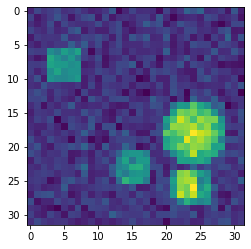

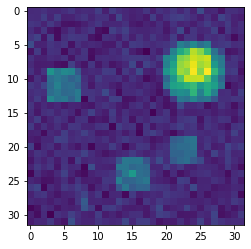

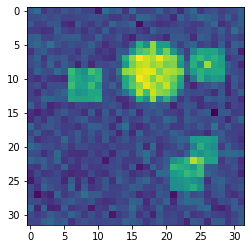

In [6]:
plot_3d(gen_random_image(32, 4, 2, 0.5))

In [7]:
from scipy.stats.distributions import randint, norm
dist_a = {
    'num_spheres': randint(3, 8), 
    'num_cubes': randint(0, 4), 
    'noise_factor': norm(1, 0.5)
}

dist_b = {
    'num_spheres': randint(1, 5), 
    'num_cubes': randint(2, 6), 
    'noise_factor': norm(0.6, 1.8)
}

In [8]:
n_images = 100
img_size = 32
a_images = []
for i in range(n_images):
    params = {k: np.abs(v.rvs()) for k, v in dist_a.items()}
    img = gen_random_image(img_size, **params)
    a_images.append((img, params))

b_images = []
for i in range(n_images):
    params = {k: np.abs(v.rvs()) for k, v in dist_b.items()}
    img = gen_random_image(img_size, **params)
    b_images.append((img, params))

In [9]:
images_a, _ = zip(*a_images)
images_b, _ = zip(*b_images)

In [10]:
import tifffile

In [11]:
np.repeat(np.zeros((5, 5, 5)), repeats=3).shape

(375,)

In [12]:
import videoio
for i in range(n_images):
    tifffile.imwrite(f'synth/{i}a.tiff', data=a_images[i][0])
    tifffile.imwrite(f'synth/{i}b.tiff', data=b_images[i][0])
#     videoio.videosave(f'synth/{i}a.mp4', np.stack([a_images[i][0], a_images[i][0], a_images[i][0]], axis=3))
#     videoio.videosave(f'synth/{i}b.mp4', np.stack([b_images[i][0], b_images[i][0], b_images[i][0]], axis=3))

In [10]:
from torch.utils.data import Dataset, DataLoader
class SynthDataset(Dataset):
    def __init__(self, images, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images = images
        self.transform = transform
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]

        if self.transform:
            img = self.transform(img)

#         return Image.fromarray(img[None, :, :, :]), torch.Tensor([idx < len(self.images)//2])        
#         print(np.stack([img, img, img]).shape)
        return (torch.Tensor(np.stack([img, img, img])), 0), torch.Tensor([idx < len(self.images)//2])

In [11]:
from lightly.data import BaseCollateFunction
import torchvision.transforms as T

class ThreeDImageCollateFunction(BaseCollateFunction):
    """Implementation of a collate function for images.

    This is an implementation of the BaseCollateFunction with a concrete
    set of transforms.

    The set of transforms is inspired by the SimCLR paper as it has shown
    to produce powerful embeddings. 

    Attributes:
        input_size:
            Size of the input image in pixels.
        cj_prob:
            Probability that color jitter is applied.
        cj_bright:
            How much to jitter brightness.
        cj_contrast:
            How much to jitter constrast.
        cj_sat:
            How much to jitter saturation.
        cj_hue:
            How much to jitter hue.
        min_scale:
            Minimum size of the randomized crop relative to the input_size.
        random_gray_scale:
            Probability of conversion to grayscale.
        gaussian_blur:
            Probability of Gaussian blur.
        kernel_size:
            Sigma of gaussian blur is kernel_size * input_size.
        vf_prob:
            Probability that vertical flip is applied.
        hf_prob:
            Probability that horizontal flip is applied.
        rr_prob:
            Probability that random (+90 degree) rotation is applied.
        normalize:
            Dictionary with 'mean' and 'std' for torchvision.transforms.Normalize.

    """

    def __init__(self,
                 input_size: int = 64,
                 cj_prob: float = 0.8,
                 cj_bright: float = 0.7,
                 cj_contrast: float = 0.7,
                 cj_sat: float = 0.7,
                 cj_hue: float = 0.2,
                 min_scale: float = 0.15,
                 random_gray_scale: float = 0.2,
                 gaussian_blur: float = 0.5,
                 kernel_size: float = 0.1,
                 vf_prob: float = 0.0,
                 hf_prob: float = 0.5,
                 rr_prob: float = 0.0):

        if isinstance(input_size, tuple):
            input_size_ = max(input_size)
        else:
            input_size_ = input_size

        transform = []

#         if normalize:
#             transform += [
#              T.Normalize(
#                 mean=normalize['mean'],
#                 std=normalize['std'])
#              ]
           
        transform = T.Compose(transform)

        super(ThreeDImageCollateFunction, self).__init__(transform)

In [12]:
import torch
from torch import nn
import torchvision
import lightly.models as models
import lightly.loss as loss
import lightly.data as data
from torch.utils.data import TensorDataset, DataLoader

# the collate function applies random transforms to the input images
collate_fn = ThreeDImageCollateFunction(input_size=32, random_gray_scale=0, gaussian_blur=0, cj_prob=0.5)

# tensor_x = torch.Tensor(np.array(images_a + images_b).reshape(n_images*2, 1, img_size, img_size, img_size)) # transform to torch tensor
# tensor_y = torch.Tensor([0]*n_images + [1]*n_images)

# create a dataset from your image folder
# my_dataset = TensorDataset(tensor_x, tensor_y) # create your datset
synth_dataset = SynthDataset(images_a + images_b)
dataset = data.LightlyDataset.from_torch_dataset(synth_dataset)
# dataset = data.LightlyDataset(input_dir='synth')


# build a PyTorch dataloader
dataloader = torch.utils.data.DataLoader(
    dataset,                # pass the dataset to the dataloader
    batch_size=32,         # a large batch size helps with the learning
    shuffle=True           # shuffling is important!
)
    

# use a resnet backbone
resnet = torchvision.models.video.r3d_18()
resnet = nn.Sequential(*list(resnet.children())[:-1])

In [13]:
# build the simsiam model
model = models.SimSiam(resnet, num_ftrs=512)

# use the SimSiam loss function
criterion = loss.SymNegCosineSimilarityLoss()

In [14]:
# get a PyTorch optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-0, weight_decay=1e-5)

In [15]:
import lightly.embedding as embedding

# put all the pieces together in a single pytorch_lightning trainable!
embedding_model = embedding.SelfSupervisedEmbedding(
    model,
    criterion,
    optimizer,
    dataloader)

# do self-supervised learning for 10 epochs
embedding_model.train_embedding(gpus=1, max_epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                       | Params
---------------------------------------------------------
0 | model     | SimSiam                    | 44 M  
1 | criterion | SymNegCosineSimilarityLoss | 0     


Epoch 0:   0%|                                                                                                  | 0/7 [00:00<?, ?it/s]torch.Size([32, 3, 32, 32, 32])


RuntimeError: Expected 5-dimensional input for 5-dimensional weight [64, 3, 3, 7, 7], but got 1-dimensional input of size [32] instead

In [ ]:
Image.fromarray(np.zeros((32, 32, 32), dtype=np.uint16))

In [45]:
!pip install --upgrade pytorch_lightning==1.0.4

  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 1.2.6
    Uninstalling pytorch-lightning-1.2.6:
      Successfully uninstalled pytorch-lightning-1.2.6


In [9]:
!pip show pytorch_lightning

Name: pytorch-lightning
Version: 1.0.4
Summary: PyTorch Lightning is the lightweight PyTorch wrapper for ML researchers. Scale your models. Write less boilerplate.
Home-page: https://github.com/PyTorchLightning/pytorch-lightning
Author: William Falcon et al.
Author-email: waf2107@columbia.edu
License: Apache-2.0
Location: c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages
Requires: tensorboard, PyYAML, torch, tqdm, fsspec, future, numpy
Required-by: lightly


In [10]:
import pandas as pd

In [14]:
embeddings = pd.read_csv('lightly_outputs/2021-04-05/17-54-32/embeddings.csv')
embeddings['label'] = embeddings.filenames.str.contains('b')

In [21]:
embeddings

,filenames,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_24,embedding_25,embedding_26,embedding_27,embedding_28,embedding_29,embedding_30,embedding_31,labels,label
0,0a.tiff,0.619477,0.169419,0.238333,0.351315,-0.056674,0.070336,-0.063018,-0.710222,0.378418,...,0.022725,-0.082249,0.338228,0.190729,-0.388715,0.915568,0.167859,-0.459651,0,False
1,0b.tiff,0.523942,0.076930,0.236226,0.321934,-0.078054,-0.002711,-0.100953,-0.441974,0.305229,...,-0.035013,-0.051445,0.235933,0.130503,-0.307735,0.711902,0.050089,-0.342854,0,True
2,10a.tiff,0.609851,0.170380,0.245791,0.352487,-0.059485,0.081091,-0.072528,-0.706542,0.371973,...,0.010466,-0.081818,0.327570,0.191664,-0.389280,0.915138,0.174637,-0.444770,0,False
3,10b.tiff,0.609851,0.170380,0.245791,0.352487,-0.059485,0.081091,-0.072528,-0.706542,0.371973,...,0.010466,-0.081818,0.327570,0.191664,-0.389280,0.915138,0.174637,-0.444770,0,True
4,11a.tiff,0.609851,0.170380,0.245791,0.352487,-0.059485,0.081091,-0.072528,-0.706542,0.371973,...,0.010466,-0.081818,0.327570,0.191664,-0.389280,0.915138,0.174637,-0.444770,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,98b.tiff,0.549136,0.126186,0.246545,0.325927,-0.085046,0.012719,-0.083475,-0.514771,0.319403,...,0.000923,-0.064013,0.269893,0.162726,-0.347578,0.756534,0.094815,-0.387546,0,True
196,99a.tiff,0.609851,0.170380,0.245791,0.352487,-0.059485,0.081091,-0.072528,-0.706542,0.371973,...,0.010466,-0.081818,0.327570,0.191664,-0.389280,0.915138,0.174637,-0.444770,0,False
197,99b.tiff,0.587101,0.183360,0.277193,0.366577,-0.055165,-0.008181,-0.050713,-0.574010,0.350513,...,0.045213,-0.074350,0.319101,0.191011,-0.423579,0.862379,0.091091,-0.432969,0,True
198,9a.tiff,0.612634,0.177726,0.285528,0.389776,-0.044687,0.011161,-0.067964,-0.597809,0.370222,...,0.046225,-0.086168,0.336176,0.181609,-0.434945,0.893205,0.111460,-0.442109,0,False


In [18]:
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import cross_validate

In [17]:
clf = LGBMClassifier(n_jobs=-1)
clf.fit(embeddings.loc[:, embeddings.columns.str.startswith('embedding')], embeddings['label'])

LGBMClassifier()

In [19]:
cross_validate(clf, embeddings.loc[:, embeddings.columns.str.startswith('embedding')], embeddings['label'], scoring='roc_auc')

{'fit_time': array([0.03399968, 0.02800131, 0.02400088, 0.02299714, 0.02300048]),
 'score_time': array([0.00399899, 0.00299931, 0.00400138, 0.00399971, 0.00300026]),
 'test_score': array([0.65   , 0.55125, 0.53   , 0.5175 , 0.78375])}